In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import glob
from matplotlib.colors import Normalize
from scipy.fft import fft, fftfreq
from scipy.signal import butter, filtfilt, decimate
from skimage.feature import canny
from skimage.transform import hough_line, hough_line_peaks


# Assigned ranges for analysis
range1=("092022", "092212")
range2=("091122", "091312")
range3=("090302", "090452")


# Data loading

In [36]:
def get_range(ts_start: str, ts_end: str, dx=5.1065, dt=0.0016):
    files = glob.glob("../data/*.npy")
    files.sort()
    
    def extract_ts(path):
        fname = path.split("\\")[-1].split("/")[-1].split(".")[0]
        return datetime.datetime.strptime("2024-05-07 " + fname, "%Y-%m-%d %H%M%S")
    
    ts_start_dt = datetime.datetime.strptime("2024-05-07 " + ts_start, "%Y-%m-%d %H%M%S")
    ts_end_dt = datetime.datetime.strptime("2024-05-07 " + ts_end, "%Y-%m-%d %H%M%S")
    
    selected = []
    timestamps = []
    for f in files:
        ts = extract_ts(f)
        if ts_start_dt <= ts <= ts_end_dt:
            selected.append(f)
            timestamps.append(ts)
    
    if not selected:
        raise ValueError("No files found between the given timestamps.")
    
    arrays = [np.load(f) for f in selected]
    data = np.concatenate(arrays)
    
    index = pd.date_range(start=timestamps[0], periods=len(data), freq=f"{dt}s")
    columns = np.arange(data.shape[1]) * dx
    df = pd.DataFrame(data=data, index=index, columns=columns)
    
    return {"data": data, "df": df, "dt": dt, "dx": dx}

# Plotting

In [37]:
def set_axis(axis_data):
    """Helper function to set axis ticks"""
    n = len(axis_data)
    positions = np.linspace(0, n-1, min(10, n))
    labels = [axis_data[int(p)] for p in positions]
    return positions, labels

def plot_data(result, figsize=(12, 16), cmap='viridis', apply_transform=True, percentiles=[3, 99]):
    """
    Plot DAS data as a heatmap (time vs distance).
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() containing 'data', 'df', 'dt', 'dx'
    figsize : tuple
        Figure size (width, height)
    cmap : str
        Colormap for the plot
    apply_transform : bool
        If True, applies mean subtraction and absolute value transform
    percentiles : list
        Percentile values [low, high] for color normalization
    
    Returns:
    --------
    fig, ax : matplotlib figure and axes objects
    """
    df = result['df'].copy()
    
    # Apply transformation
    if apply_transform:
        df -= df.mean()
        df = np.abs(df)
    
    # Normalize using percentiles
    low, high = np.percentile(df, percentiles)
    norm = Normalize(vmin=low, vmax=high, clip=True)
    
    fig = plt.figure(figsize=figsize)
    ax = plt.axes()
    
    # Plot the data
    im = ax.imshow(df, interpolation='none', aspect='auto', norm=norm, cmap=cmap)
    
    plt.ylabel('time')
    plt.xlabel('space [m]')
    
    # Add colorbar with custom positioning
    cax = fig.add_axes([ax.get_position().x1+0.06, ax.get_position().y0, 0.02, ax.get_position().height])
    plt.colorbar(im, cax=cax)
    
    # Set axis ticks
    x_positions, x_labels = set_axis(df.columns)
    ax.set_xticks(x_positions, np.round(x_labels))
    
    y_positions, y_labels = set_axis(df.index.time)
    ax.set_yticks(y_positions, y_labels)
    
    plt.show()
    
    return fig, ax

def plot_comparison(result1, result2, title1="Original", title2="Processed", 
                    figsize=(24, 16), cmap='viridis', apply_transform=True, percentiles=[3, 99]):
    """
    Plot two DAS datasets side by side for comparison.
    
    Parameters:
    -----------
    result1, result2 : dict
        Dictionaries returned by get_range() or filter functions
    title1, title2 : str
        Titles for the left and right plots
    figsize : tuple
        Figure size (width, height)
    cmap : str
        Colormap for the plots
    apply_transform : bool
        If True, applies mean subtraction and absolute value transform
    percentiles : list
        Percentile values [low, high] for color normalization
    
    Returns:
    --------
    fig, (ax1, ax2) : matplotlib figure and axes objects
    """
    df1 = result1['df'].copy()
    df2 = result2['df'].copy()
    
    # Apply transformation
    if apply_transform:
        df1 -= df1.mean()
        df1 = np.abs(df1)
        df2 -= df2.mean()
        df2 = np.abs(df2)
    
    # Normalize using percentiles
    low, high = np.percentile(df1, percentiles)
    low2, high2 = np.percentile(df2, percentiles)
    norm = Normalize(vmin=low, vmax=high, clip=True)
    norm2 = Normalize(vmin=low2, vmax=high2, clip=True)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Plot left (original)
    im1 = ax1.imshow(df1, interpolation='none', aspect='auto', norm=norm, cmap=cmap)
    ax1.set_ylabel('time')
    ax1.set_xlabel('space [m]')
    ax1.set_title(title1)
    
    x_positions1, x_labels1 = set_axis(df1.columns)
    ax1.set_xticks(x_positions1, np.round(x_labels1))
    y_positions1, y_labels1 = set_axis(df1.index.time)
    ax1.set_yticks(y_positions1, y_labels1)
    
    # Plot right (processed)
    im2 = ax2.imshow(df2, interpolation='none', aspect='auto', norm=norm2, cmap=cmap)
    ax2.set_ylabel('time')
    ax2.set_xlabel('space [m]')
    ax2.set_title(title2)
    
    x_positions2, x_labels2 = set_axis(df2.columns)
    ax2.set_xticks(x_positions2, np.round(x_labels2))
    y_positions2, y_labels2 = set_axis(df2.index.time)
    ax2.set_yticks(y_positions2, y_labels2)
    
    # Add colorbars
    cbar1 = plt.colorbar(im1, ax=ax1)
    cbar1.set_label('Amplitude')
    cbar2 = plt.colorbar(im2, ax=ax2)
    cbar2.set_label('Amplitude')
    
    plt.tight_layout()
    plt.show()
    
    return fig, (ax1, ax2)

# Preprocessing

In [58]:
def bandpass_filter(result, lowcut=5, highcut=50, order=4):
    """
    Apply bandpass filter to DAS data to isolate vehicle frequencies.
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() containing 'data', 'df', 'dt', 'dx'
    lowcut : float
        Low cutoff frequency in Hz (default: 5 Hz)
    highcut : float
        High cutoff frequency in Hz (default: 50 Hz)
    order : int
        Filter order (default: 4)
    
    Returns:
    --------
    dict : Same structure as input with filtered data
        {'data': filtered_array, 'df': filtered_dataframe, 'dt': dt, 'dx': dx}
    """
    dt = result['dt']
    dx = result['dx']
    data = result['data']
    df = result['df']
    
    # Calculate sampling frequency
    fs = 1.0 / dt
    
    # Normalize cutoff frequencies
    nyquist = fs / 2.0
    low = lowcut / nyquist
    high = highcut / nyquist
    
    # Design Butterworth bandpass filter
    b, a = butter(order, [low, high], btype='band')
    
    # Apply filter to each spatial channel (column)
    filtered_data = np.zeros_like(data)
    for i in range(data.shape[1]):
        filtered_data[:, i] = filtfilt(b, a, data[:, i])
    
    # Create filtered DataFrame with same index and columns
    filtered_df = pd.DataFrame(
        data=filtered_data,
        index=df.index,
        columns=df.columns
    )
    
    return {
        'data': filtered_data,
        'df': filtered_df,
        'dt': dt,
        'dx': dx
    }

def median_subtract_filter(result):
    """
    Subtract the median value from each channel to remove DC offset and baseline drift.
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() containing 'data', 'df', 'dt', 'dx'
    
    Returns:
    --------
    dict : Same structure as input with median-subtracted data
        {'data': filtered_array, 'df': filtered_dataframe, 'dt': dt, 'dx': dx}
    """
    dt = result['dt']
    dx = result['dx']
    data = result['data']
    df = result['df']
    
    # Subtract median from each channel (column)
    filtered_data = np.zeros_like(data)
    for i in range(data.shape[1]):
        filtered_data[:, i] = data[:, i] - np.median(data[:, i])
    
    # Create filtered DataFrame with same index and columns
    filtered_df = pd.DataFrame(
        data=filtered_data,
        index=df.index,
        columns=df.columns
    )
    
    return {
        'data': filtered_data,
        'df': filtered_df,
        'dt': dt,
        'dx': dx
    }
    
def zero_columns(data, col_start, col_end):
    # Zero out specified columns in the DAS data.
    dt = data['dt']
    dx = data['dx']
    array = data['data']
    df = data['df']
    modified_array = array.copy()
    modified_array[:, col_start:col_end] = 0
    modified_df = pd.DataFrame(
        data=modified_array,
        index=df.index,
        columns=df.columns
    )
    
    return {
        'data': modified_array,
        'df': modified_df,
        'dt': dt,
        'dx': dx
    }

def power_data_to_x(data, power=2):
    # Raise the absolute value of the data to a specified power.
    dt = data['dt']
    dx = data['dx']
    array = data['data']
    df = data['df']
    modified_array = np.abs(array) ** power
    modified_df = pd.DataFrame(
        data=modified_array,
        index=df.index,
        columns=df.columns
    )
    
    return {
        'data': modified_array,
        'df': modified_df,
        'dt': dt,
        'dx': dx
    }
    

# Other functions

In [122]:
def find_channel_frequencies(result, channel_index=24, threshold_percentile=85, 
                            merge_gap=50, min_sector_length=3):
    """
    Find frequencies of continuous high-amplitude sectors on a specific channel.
    
    This function identifies continuous segments (sectors) on a single channel that
    exceed a threshold, merges nearby sectors, then calculates their frequencies based on duration.
    
    Parameters:
    -----------
    result : dict
        Dictionary from get_range() containing 'data', 'df', 'dt', 'dx'
    channel_index : int
        Index of the channel to analyze (default: 24)
    threshold_percentile : float
        Percentile threshold for sector detection (default: 85)
    merge_gap : int
        Maximum gap (in samples) between sectors to merge them (default: 50)
    min_sector_length : int
        Minimum sector length (in samples) to keep (default: 3)
    
    Returns:
    --------
    dict : Analysis results containing:
        'frequencies': array of frequencies [Hz] for each detected sector group
        'durations': array of sector durations [seconds]
        'sector_lengths': array of sector lengths [samples]
        'starts': array of sector start indices
        'ends': array of sector end indices
        'num_merged': array showing how many original sectors were merged
    """
    dt = result['dt']
    data = result['data']
    
    # Get the specific channel data
    channel_data = data[:, channel_index]
    
    # Calculate threshold
    threshold = np.percentile(np.abs(channel_data), threshold_percentile)
    
    # Create binary signal where channel exceeds threshold
    binary_signal = (np.abs(channel_data) > threshold).astype(int)
    
    # Find continuous segments (sectors)
    # Where signal changes from 0 to 1 or 1 to 0
    diff = np.diff(np.concatenate(([0], binary_signal, [0])))
    starts_raw = np.where(diff == 1)[0]
    ends_raw = np.where(diff == -1)[0]
    
    # Filter out very short sectors
    sector_lengths_raw = ends_raw - starts_raw
    valid_mask = sector_lengths_raw >= min_sector_length
    starts_raw = starts_raw[valid_mask]
    ends_raw = ends_raw[valid_mask]
    
    print(f"Initial sectors detected: {len(starts_raw)}")
    
    # Merge nearby sectors
    if len(starts_raw) == 0:
        starts = np.array([])
        ends = np.array([])
        num_merged = np.array([])
    else:
        merged_starts = [starts_raw[0]]
        merged_ends = [ends_raw[0]]
        num_merged_list = [1]
        
        for i in range(1, len(starts_raw)):
            gap = starts_raw[i] - merged_ends[-1]
            
            if gap <= merge_gap:
                # Merge with previous sector
                merged_ends[-1] = ends_raw[i]
                num_merged_list[-1] += 1
            else:
                # Start new sector
                merged_starts.append(starts_raw[i])
                merged_ends.append(ends_raw[i])
                num_merged_list.append(1)
        
        starts = np.array(merged_starts)
        ends = np.array(merged_ends)
        num_merged = np.array(num_merged_list)
    
    # Calculate properties for each merged sector
    sector_lengths = ends - starts  # Length in samples
    durations = sector_lengths * dt  # Duration in seconds
    
    # Calculate frequency for each sector: f = 1 / T
    frequencies = np.array([1.0 / duration if duration > 0 else 0 for duration in durations])
    
    print("="*70)
    print(f"CHANNEL {channel_index} FREQUENCY ANALYSIS")
    print("="*70)
    print(f"\nData parameters:")
    print(f"  Temporal resolution (dt): {dt*1000:.2f} ms")
    print(f"  Channel index: {channel_index}")
    print(f"  Threshold (percentile {threshold_percentile}): {threshold:.6f}")
    print(f"  Merge gap: {merge_gap} samples ({merge_gap * dt * 1000:.2f} ms)")
    print(f"  Min sector length: {min_sector_length} samples ({min_sector_length * dt * 1000:.2f} ms)")
    print(f"  Merged sectors detected: {len(frequencies)}")
    
    if len(frequencies) > 0:
        print(f"\n{'='*70}")
        print(f"DETECTED MERGED SECTORS:")
        print(f"{'='*70}")
        print(f"{'#':<6} {'Start':<10} {'End':<10} {'Length':<12} {'Duration':<15} {'Frequency':<12} {'Merged':<8}")
        print(f"{'-'*70}")
        
        for i, (start, end, length, duration, freq, n_merged) in enumerate(zip(starts, ends, sector_lengths, durations, frequencies, num_merged)):
            if i < 20:  # Show first 20
                print(f"{i+1:<6} {start:<10} {end:<10} {length:<12} {duration*1000:>10.2f} ms   {freq:>10.2f} Hz   {n_merged:<8}")
        
        if len(frequencies) > 20:
            print(f"... and {len(frequencies) - 20} more sectors")
        
        print(f"{'='*70}")
        print(f"\nSUMMARY STATISTICS:")
        print(f"  Total sectors: {len(frequencies)}")
        print(f"  Sector lengths: {np.min(sector_lengths)} to {np.max(sector_lengths)} samples")
        print(f"  Durations: {np.min(durations)*1000:.2f} to {np.max(durations)*1000:.2f} ms")
        print(f"  Frequencies: {np.min(frequencies):.2f} to {np.max(frequencies):.2f} Hz")
        print(f"  Mean frequency: {np.mean(frequencies):.2f} Hz")
        print(f"  Median frequency: {np.median(frequencies):.2f} Hz")
        
        # Visualization
        fig, axes = plt.subplots(2, 2, figsize=(20, 10))
        
        # Plot 1: Channel signal with threshold
        ax = axes[0, 0]
        time_axis = np.arange(len(channel_data)) * dt
        ax.plot(time_axis, channel_data, 'b-', linewidth=0.5, alpha=0.7, label='Signal')
        ax.axhline(threshold, color='r', linestyle='--', linewidth=2, label=f'Threshold ({threshold_percentile}%)')
        ax.axhline(-threshold, color='r', linestyle='--', linewidth=2)
        ax.set_xlabel('Time [s]')
        ax.set_ylabel('Amplitude')
        ax.set_title(f'Channel {channel_index} Signal', fontsize=14, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Plot 2: Binary signal with sectors highlighted
        ax = axes[0, 1]
        ax.plot(time_axis, binary_signal, 'k-', linewidth=1)
        for start, end in zip(starts[:50], ends[:50]):  # Highlight first 50 sectors
            ax.axvspan(start * dt, end * dt, alpha=0.3, color='green')
        ax.set_xlabel('Time [s]')
        ax.set_ylabel('Binary (0/1)')
        ax.set_title('Detected Sectors (first 50 highlighted)', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        # Plot 3: Frequency histogram
        ax = axes[1, 0]
        ax.hist(frequencies, bins=50, edgecolor='black', alpha=0.7)
        ax.axvline(np.mean(frequencies), color='r', linestyle='--', 
                   linewidth=2, label=f'Mean: {np.mean(frequencies):.2f} Hz')
        ax.axvline(np.median(frequencies), color='g', linestyle='--', 
                   linewidth=2, label=f'Median: {np.median(frequencies):.2f} Hz')
        ax.set_xlabel('Frequency [Hz]')
        ax.set_ylabel('Count')
        ax.set_title('Frequency Distribution', fontsize=14, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Plot 4: Duration vs Frequency scatter
        ax = axes[1, 1]
        ax.scatter(durations * 1000, frequencies, alpha=0.5, s=20)
        ax.set_xlabel('Duration [ms]')
        ax.set_ylabel('Frequency [Hz]')
        ax.set_title('Duration vs Frequency', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    else:
        print("\nNo sectors detected above threshold.")
    
    print(f"{'='*70}\n")
    
    return {
        'frequencies': frequencies,
        'durations': durations,
        'sector_lengths': sector_lengths,
        'starts': starts,
        'ends': ends,
        'num_merged': num_merged,
        'channel_index': channel_index,
        'threshold': threshold
    }

def notch_filter_frequencies(result, frequencies_to_remove, bandwidth=2.0, order=2):
    """
    Apply notch filters to remove specific frequencies from DAS data.
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() containing 'data', 'df', 'dt', 'dx'
    frequencies_to_remove : array-like
        List or array of frequencies [Hz] to remove from the signal
    bandwidth : float
        Bandwidth of each notch filter in Hz (default: 2.0)
    order : int
        Filter order for each notch (default: 2)
    
    Returns:
    --------
    dict : Same structure as input with filtered data
        {'data': filtered_array, 'df': filtered_dataframe, 'dt': dt, 'dx': dx}
    """
    from scipy.signal import iirnotch
    
    dt = result['dt']
    dx = result['dx']
    data = result['data'].copy()
    df = result['df']
    
    # Calculate sampling frequency
    fs = 1.0 / dt
    
    print("="*70)
    print("NOTCH FILTERING")
    print("="*70)
    print(f"Sampling frequency: {fs:.2f} Hz")
    print(f"Removing {len(frequencies_to_remove)} frequencies:")
    
    # Apply notch filter for each frequency
    filtered_data = data.copy()
    
    for freq in frequencies_to_remove:
        if freq <= 0 or freq >= fs / 2:
            print(f"  Skipping {freq:.2f} Hz (out of valid range)")
            continue
        
        # Design notch filter
        # Q factor determines bandwidth: BW = freq / Q
        Q = freq / bandwidth
        b, a = iirnotch(freq, Q, fs)
        
        # Apply filter to each spatial channel
        for i in range(filtered_data.shape[1]):
            filtered_data[:, i] = filtfilt(b, a, filtered_data[:, i])
        
        print(f"  Removed {freq:.2f} Hz (Q={Q:.2f}, BW={bandwidth:.2f} Hz)")
    
    # Create filtered DataFrame
    filtered_df = pd.DataFrame(
        data=filtered_data,
        index=df.index,
        columns=df.columns
    )
    
    print("="*70 + "\n")
    
    return {
        'data': filtered_data,
        'df': filtered_df,
        'dt': dt,
        'dx': dx
    }

def bandstop_filter_frequencies(result, frequencies_to_remove, bandwidth=5.0, order=4):
    """
    Apply bandstop (band-reject) filters to remove specific frequency bands from DAS data.
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() containing 'data', 'df', 'dt', 'dx'
    frequencies_to_remove : array-like
        List or array of center frequencies [Hz] to remove from the signal
    bandwidth : float
        Bandwidth around each center frequency to remove in Hz (default: 5.0)
    order : int
        Filter order (default: 4)
    
    Returns:
    --------
    dict : Same structure as input with filtered data
        {'data': filtered_array, 'df': filtered_dataframe, 'dt': dt, 'dx': dx}
    """
    dt = result['dt']
    dx = result['dx']
    data = result['data'].copy()
    df = result['df']
    
    # Calculate sampling frequency
    fs = 1.0 / dt
    nyquist = fs / 2.0
    
    print("="*70)
    print("BANDSTOP FILTERING")
    print("="*70)
    print(f"Sampling frequency: {fs:.2f} Hz")
    print(f"Removing {len(frequencies_to_remove)} frequency bands:")
    
    # Apply bandstop filter for each frequency
    filtered_data = data.copy()
    
    for freq in frequencies_to_remove:
        # Calculate lowcut and highcut
        lowcut = freq - bandwidth / 2
        highcut = freq + bandwidth / 2
        
        # Validate frequency range
        if lowcut <= 0 or highcut >= nyquist:
            print(f"  Skipping {freq:.2f} Hz (band {lowcut:.2f}-{highcut:.2f} Hz out of valid range)")
            continue
        
        # Normalize cutoff frequencies
        low = lowcut / nyquist
        high = highcut / nyquist
        
        # Design bandstop filter
        b, a = butter(order, [low, high], btype='bandstop')
        
        # Apply filter to each spatial channel
        for i in range(filtered_data.shape[1]):
            filtered_data[:, i] = filtfilt(b, a, filtered_data[:, i])
        
        print(f"  Removed {lowcut:.2f}-{highcut:.2f} Hz (center: {freq:.2f} Hz)")
    
    # Create filtered DataFrame
    filtered_df = pd.DataFrame(
        data=filtered_data,
        index=df.index,
        columns=df.columns
    )
    
    print("="*70 + "\n")
    
    return {
        'data': filtered_data,
        'df': filtered_df,
        'dt': dt,
        'dx': dx
    }

def bandpass_keep_frequencies(result, frequencies_to_keep, bandwidth=5.0, order=4):
    """
    Apply bandpass filters to KEEP ONLY specific frequencies from DAS data.
    All other frequencies will be removed.
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() containing 'data', 'df', 'dt', 'dx'
    frequencies_to_keep : array-like
        List or array of center frequencies [Hz] to KEEP in the signal
    bandwidth : float
        Bandwidth around each center frequency to keep in Hz (default: 5.0)
    order : int
        Filter order (default: 4)
    
    Returns:
    --------
    dict : Same structure as input with filtered data
        {'data': filtered_array, 'df': filtered_dataframe, 'dt': dt, 'dx': dx}
    """
    dt = result['dt']
    dx = result['dx']
    data = result['data'].copy()
    df = result['df']
    
    # Calculate sampling frequency
    fs = 1.0 / dt
    nyquist = fs / 2.0
    
    print("="*70)
    print("BANDPASS KEEP ONLY SPECIFIC FREQUENCIES")
    print("="*70)
    print(f"Sampling frequency: {fs:.2f} Hz")
    print(f"Keeping {len(frequencies_to_keep)} frequency bands:")
    
    # Start with zeros - we'll add each frequency band
    filtered_data = np.zeros_like(data)
    
    for freq in frequencies_to_keep:
        # Calculate lowcut and highcut
        lowcut = freq - bandwidth / 2
        highcut = freq + bandwidth / 2
        
        # Validate frequency range
        if lowcut <= 0 or highcut >= nyquist:
            print(f"  Skipping {freq:.2f} Hz (band {lowcut:.2f}-{highcut:.2f} Hz out of valid range)")
            continue
        
        # Normalize cutoff frequencies
        low = lowcut / nyquist
        high = highcut / nyquist
        
        # Design bandpass filter
        b, a = butter(order, [low, high], btype='bandpass')
        
        # Apply filter to each spatial channel and ADD to result
        for i in range(data.shape[1]):
            filtered_data[:, i] += filtfilt(b, a, data[:, i])
        
        print(f"  Kept {lowcut:.2f}-{highcut:.2f} Hz (center: {freq:.2f} Hz)")
    
    # Create filtered DataFrame
    filtered_df = pd.DataFrame(
        data=filtered_data,
        index=df.index,
        columns=df.columns
    )
    
    print("="*70 + "\n")
    
    return {
        'data': filtered_data,
        'df': filtered_df,
        'dt': dt,
        'dx': dx
    }


In [154]:
def find_channel_frequencies_fft(result, channel_index=24, threshold_percentile=85, 
                                merge_gap=50, min_sector_length=3, 
                                min_freq=5, max_freq=50, top_n_peaks=1):
    """
    Find dominant signal frequencies using FFT analysis of high-amplitude sectors.
    
    Instead of calculating f=1/duration, this function applies FFT to each detected
    sector to find the actual oscillation frequencies in the signal content.
    
    Parameters:
    -----------
    result : dict
        Dictionary from get_range() containing 'data', 'df', 'dt', 'dx'
    channel_index : int
        Index of the channel to analyze (default: 24)
    threshold_percentile : float
        Percentile threshold for sector detection (default: 85)
    merge_gap : int
        Maximum gap (in samples) between sectors to merge them (default: 50)
    min_sector_length : int
        Minimum sector length (in samples) to keep (default: 3)
    min_freq : float
        Minimum frequency to consider in FFT analysis [Hz] (default: 5)
    max_freq : float
        Maximum frequency to consider in FFT analysis [Hz] (default: 50)
    top_n_peaks : int
        Number of top frequency peaks to extract per sector (default: 1)
    
    Returns:
    --------
    dict : Analysis results containing:
        'frequencies': array of dominant frequencies [Hz] found via FFT
        'peak_powers': array of FFT peak powers for each frequency
        'sector_frequencies': list of arrays, each containing top frequencies for one sector
        'durations': array of sector durations [seconds]
        'sector_lengths': array of sector lengths [samples]
        'starts': array of sector start indices
        'ends': array of sector end indices
        'num_merged': array showing how many original sectors were merged
    """
    from scipy.fft import rfft, rfftfreq
    
    dt = result['dt']
    data = result['data']
    fs = 1.0 / dt
    
    # Get the specific channel data
    channel_data = data[:, channel_index]
    
    # Calculate threshold
    threshold = np.percentile(np.abs(channel_data), threshold_percentile)
    
    # Create binary signal where channel exceeds threshold
    binary_signal = (np.abs(channel_data) > threshold).astype(int)
    
    # Find continuous segments (sectors)
    diff = np.diff(np.concatenate(([0], binary_signal, [0])))
    starts_raw = np.where(diff == 1)[0]
    ends_raw = np.where(diff == -1)[0]
    
    # Filter out very short sectors
    sector_lengths_raw = ends_raw - starts_raw
    valid_mask = sector_lengths_raw >= min_sector_length
    starts_raw = starts_raw[valid_mask]
    ends_raw = ends_raw[valid_mask]
    
    print(f"Initial sectors detected: {len(starts_raw)}")
    
    # Merge nearby sectors
    if len(starts_raw) == 0:
        starts = np.array([])
        ends = np.array([])
        num_merged = np.array([])
    else:
        merged_starts = [starts_raw[0]]
        merged_ends = [ends_raw[0]]
        num_merged_list = [1]
        
        for i in range(1, len(starts_raw)):
            gap = starts_raw[i] - merged_ends[-1]
            
            if gap <= merge_gap:
                merged_ends[-1] = ends_raw[i]
                num_merged_list[-1] += 1
            else:
                merged_starts.append(starts_raw[i])
                merged_ends.append(ends_raw[i])
                num_merged_list.append(1)
        
        starts = np.array(merged_starts)
        ends = np.array(merged_ends)
        num_merged = np.array(num_merged_list)
    
    # Calculate basic properties
    sector_lengths = ends - starts
    durations = sector_lengths * dt
    
    # FFT analysis for each sector
    all_frequencies = []
    all_peak_powers = []
    sector_frequencies_list = []
    
    for start, end in zip(starts, ends):
        # Extract sector signal
        sector_signal = channel_data[start:end]
        sector_length = len(sector_signal)
        
        # Apply FFT
        fft_result = rfft(sector_signal)
        fft_freqs = rfftfreq(sector_length, dt)
        fft_power = np.abs(fft_result)
        
        # Filter to frequency range of interest
        freq_mask = (fft_freqs >= min_freq) & (fft_freqs <= max_freq)
        valid_freqs = fft_freqs[freq_mask]
        valid_power = fft_power[freq_mask]
        
        if len(valid_freqs) == 0:
            continue
        
        # Find top N peaks
        n_peaks = min(top_n_peaks, len(valid_power))
        top_indices = np.argpartition(valid_power, -n_peaks)[-n_peaks:]
        top_indices = top_indices[np.argsort(valid_power[top_indices])[::-1]]
        
        sector_freqs = valid_freqs[top_indices]
        sector_powers = valid_power[top_indices]
        
        # Store results
        sector_frequencies_list.append(sector_freqs)
        all_frequencies.extend(sector_freqs)
        all_peak_powers.extend(sector_powers)
    
    frequencies = np.array(all_frequencies)
    peak_powers = np.array(all_peak_powers)
    
    print("="*70)
    print(f"CHANNEL {channel_index} FFT FREQUENCY ANALYSIS")
    print("="*70)
    print(f"\nData parameters:")
    print(f"  Temporal resolution (dt): {dt*1000:.2f} ms")
    print(f"  Sampling frequency (fs): {fs:.2f} Hz")
    print(f"  Channel index: {channel_index}")
    print(f"  Threshold (percentile {threshold_percentile}): {threshold:.6f}")
    print(f"  Merge gap: {merge_gap} samples ({merge_gap * dt * 1000:.2f} ms)")
    print(f"  Min sector length: {min_sector_length} samples ({min_sector_length * dt * 1000:.2f} ms)")
    print(f"  Frequency range: {min_freq}-{max_freq} Hz")
    print(f"  Top peaks per sector: {top_n_peaks}")
    print(f"  Merged sectors detected: {len(starts)}")
    print(f"  Total frequencies extracted: {len(frequencies)}")
    
    if len(frequencies) > 0:
        print(f"\n{'='*70}")
        print(f"DETECTED FREQUENCIES (via FFT):")
        print(f"{'='*70}")
        print(f"{'#':<6} {'Start':<10} {'End':<10} {'Length':<12} {'Duration':<15} {'Frequency':<12} {'Power':<12}")
        print(f"{'-'*70}")
        
        displayed = 0
        for i, (start, end, length, duration, n_merged) in enumerate(zip(starts, ends, sector_lengths, durations, num_merged)):
            if i < len(sector_frequencies_list):
                for freq, power in zip(sector_frequencies_list[i], 
                                      [peak_powers[j] for j in range(len(peak_powers)) 
                                       if j < len(sector_frequencies_list[i])]):
                    if displayed < 20:
                        print(f"{i+1:<6} {start:<10} {end:<10} {length:<12} {duration*1000:>10.2f} ms   {freq:>10.2f} Hz   {power:>10.2e}")
                        displayed += 1
        
        if len(frequencies) > 20:
            print(f"... and {len(frequencies) - 20} more frequencies")
        
        print(f"{'='*70}")
        print(f"\nSUMMARY STATISTICS:")
        print(f"  Total sectors: {len(starts)}")
        print(f"  Total frequencies: {len(frequencies)}")
        print(f"  Frequency range: {np.min(frequencies):.2f} to {np.max(frequencies):.2f} Hz")
        print(f"  Mean frequency: {np.mean(frequencies):.2f} Hz")
        print(f"  Median frequency: {np.median(frequencies):.2f} Hz")
        
        # Visualization
        fig, axes = plt.subplots(2, 2, figsize=(20, 10))
        
        # Plot 1: Channel signal with threshold
        ax = axes[0, 0]
        time_axis = np.arange(len(channel_data)) * dt
        ax.plot(time_axis, channel_data, 'b-', linewidth=0.5, alpha=0.7, label='Signal')
        ax.axhline(threshold, color='r', linestyle='--', linewidth=2, label=f'Threshold ({threshold_percentile}%)')
        ax.axhline(-threshold, color='r', linestyle='--', linewidth=2)
        ax.set_xlabel('Time [s]')
        ax.set_ylabel('Amplitude')
        ax.set_title(f'Channel {channel_index} Signal', fontsize=14, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Plot 2: Binary signal with sectors highlighted
        ax = axes[0, 1]
        ax.plot(time_axis, binary_signal, 'k-', linewidth=1)
        for start, end in zip(starts[:50], ends[:50]):
            ax.axvspan(start * dt, end * dt, alpha=0.3, color='green')
        ax.set_xlabel('Time [s]')
        ax.set_ylabel('Binary (0/1)')
        ax.set_title('Detected Sectors (first 50 highlighted)', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        # Plot 3: Frequency histogram
        ax = axes[1, 0]
        ax.hist(frequencies, bins=50, edgecolor='black', alpha=0.7)
        ax.axvline(np.mean(frequencies), color='r', linestyle='--', 
                   linewidth=2, label=f'Mean: {np.mean(frequencies):.2f} Hz')
        ax.axvline(np.median(frequencies), color='g', linestyle='--', 
                   linewidth=2, label=f'Median: {np.median(frequencies):.2f} Hz')
        ax.set_xlabel('Frequency [Hz]')
        ax.set_ylabel('Count')
        ax.set_title('FFT Frequency Distribution', fontsize=14, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Plot 4: Frequency vs Power scatter
        ax = axes[1, 1]
        ax.scatter(frequencies, peak_powers, alpha=0.5, s=20)
        ax.set_xlabel('Frequency [Hz]')
        ax.set_ylabel('FFT Power')
        ax.set_title('Frequency vs FFT Power', fontsize=14, fontweight='bold')
        ax.set_yscale('log')
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    else:
        print("\nNo frequencies detected in specified range.")
    
    print(f"{'='*70}\n")
    
    return {
        'frequencies': frequencies,
        'peak_powers': peak_powers,
        'sector_frequencies': sector_frequencies_list,
        'durations': durations,
        'sector_lengths': sector_lengths,
        'starts': starts,
        'ends': ends,
        'num_merged': num_merged,
        'channel_index': channel_index,
        'threshold': threshold
    }

In [191]:
def percentile_filter(result, lower_percentile=10, upper_percentile=90):
    """
    Filter data to keep only values between specified percentiles.
    Values outside the range are set to the corresponding percentile boundary.
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() containing 'data', 'df', 'dt', 'dx'
    lower_percentile : float
        Lower percentile threshold (0-100, default: 10)
    upper_percentile : float
        Upper percentile threshold (0-100, default: 90)
    
    Returns:
    --------
    dict : Same structure as input with filtered data
        {'data': filtered_array, 'df': filtered_dataframe, 'dt': dt, 'dx': dx}
    """
    dt = result['dt']
    dx = result['dx']
    data = result['data'].copy()
    df = result['df']
    
    # Calculate percentile thresholds
    lower_threshold = np.percentile(data, lower_percentile)
    upper_threshold = np.percentile(data, upper_percentile)
    
    print("="*70)
    print("PERCENTILE FILTERING")
    print("="*70)
    print(f"Lower percentile ({lower_percentile}%): {lower_threshold:.6f}")
    print(f"Upper percentile ({upper_percentile}%): {upper_threshold:.6f}")
    
    # Clip values to percentile range
    filtered_data = np.clip(data, lower_threshold, upper_threshold)
    
    # Calculate statistics
    original_range = np.max(data) - np.min(data)
    filtered_range = upper_threshold - lower_threshold
    percent_reduced = (1 - filtered_range / original_range) * 100
    
    print(f"\nOriginal data range: {np.min(data):.6f} to {np.max(data):.6f}")
    print(f"Filtered data range: {lower_threshold:.6f} to {upper_threshold:.6f}")
    print(f"Range reduction: {percent_reduced:.2f}%")
    print("="*70 + "\n")
    
    # Create filtered DataFrame
    filtered_df = pd.DataFrame(
        data=filtered_data,
        index=df.index,
        columns=df.columns
    )
    
    return {
        'data': filtered_data,
        'df': filtered_df,
        'dt': dt,
        'dx': dx
    }

In [ ]:
def horizontal_closing_filter(result, kernel_size=5, threshold_percentile=50):
    """
    Apply morphological closing filter horizontally to fill gaps in high-intensity areas.
    This connects broken line segments along the time axis (horizontal direction).
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() containing 'data', 'df', 'dt', 'dx'
    kernel_size : int
        Size of the horizontal structuring element (default: 5)
        Larger values close bigger gaps
    threshold_percentile : float
        Percentile threshold to binarize data before morphological operation (default: 50)
        Higher values = more selective (only strongest signals)
    
    Returns:
    --------
    dict : Same structure as input with filtered data
        {'data': filtered_array, 'df': filtered_dataframe, 'dt': dt, 'dx': dx}
    """
    from scipy.ndimage import binary_closing
    
    dt = result['dt']
    dx = result['dx']
    data = result['data'].copy()
    df = result['df']
    
    # Calculate threshold for binarization
    threshold = np.percentile(np.abs(data), threshold_percentile)
    
    print("="*70)
    print("HORIZONTAL CLOSING FILTER")
    print("="*70)
    print(f"Kernel size: {kernel_size} samples ({kernel_size * dt * 1000:.2f} ms)")
    print(f"Threshold percentile: {threshold_percentile}%")
    print(f"Threshold value: {threshold:.6f}")
    
    # Create horizontal structuring element (1 x kernel_size)
    # This only operates along time axis (rows), not space axis (columns)
    structure = np.zeros((1, kernel_size))
    structure[0, :] = 1
    
    print(f"Structuring element shape: {structure.shape} (vertical x horizontal)")
    
    # Process each channel independently
    filtered_data = np.zeros_like(data)
    
    for i in range(data.shape[1]):
        channel_data = data[:, i]
        
        # Binarize: 1 where above threshold, 0 elsewhere
        binary_data = (np.abs(channel_data) > threshold).astype(int)
        
        # Apply morphological closing horizontally
        # This fills small gaps between high-intensity regions
        closed_binary = binary_closing(binary_data.reshape(-1, 1), structure=structure)
        
        # Apply binary mask to original data
        # Where closing filled gaps, interpolate values
        filled_mask = closed_binary.flatten()
        filtered_channel = channel_data.copy()
        
        # For newly filled regions, use interpolated values
        newly_filled = (filled_mask == 1) & (binary_data == 0)
        if np.any(newly_filled):
            # Simple interpolation: use mean of surrounding high values
            filtered_channel[newly_filled] = np.mean(channel_data[binary_data == 1]) if np.any(binary_data) else 0
        
        filtered_data[:, i] = filtered_channel
    
    # Calculate statistics
    original_high_intensity = np.sum(np.abs(data) > threshold)
    filtered_high_intensity = np.sum(np.abs(filtered_data) > threshold)
    added_samples = filtered_high_intensity - original_high_intensity
    
    print(f"\nOriginal high-intensity samples: {original_high_intensity}")
    print(f"After closing: {filtered_high_intensity}")
    print(f"Samples added (gaps filled): {added_samples}")
    print(f"Percentage increase: {(added_samples / original_high_intensity * 100):.2f}%")
    print("="*70 + "\n")
    
    # Create filtered DataFrame
    filtered_df = pd.DataFrame(
        data=filtered_data,
        index=df.index,
        columns=df.columns
    )
    
    return {
        'data': filtered_data,
        'df': filtered_df,
        'dt': dt,
        'dx': dx
    }

In [291]:
def horizontal_sobel_filter(result):
    """
    Apply horizontal Sobel filter to detect edges along the time axis.
    This enhances horizontal features like vehicle signatures moving across channels.
    
    The Sobel operator calculates the gradient in the horizontal direction,
    highlighting transitions and edges in the time domain.
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() containing 'data', 'df', 'dt', 'dx'
    
    Returns:
    --------
    dict : Same structure as input with Sobel-filtered data
        {'data': filtered_array, 'df': filtered_dataframe, 'dt': dt, 'dx': dx}
    """
    from scipy.ndimage import sobel
    
    dt = result['dt']
    dx = result['dx']
    data = result['data'].copy()
    df = result['df']
    
    print("="*70)
    print("HORIZONTAL SOBEL FILTER")
    print("="*70)
    print(f"Data shape: {data.shape} (time x space)")
    print(f"Applying horizontal gradient detection...")
    
    # Apply horizontal Sobel filter
    # axis=1 means horizontal direction (along time axis)
    filtered_data = sobel(data, axis=1)
    
    # Calculate statistics
    original_mean = np.mean(np.abs(data))
    filtered_mean = np.mean(np.abs(filtered_data))
    original_max = np.max(np.abs(data))
    filtered_max = np.max(np.abs(filtered_data))
    
    print(f"\nOriginal data:")
    print(f"  Mean absolute value: {original_mean:.6f}")
    print(f"  Max absolute value: {original_max:.6f}")
    print(f"\nFiltered data (horizontal edges):")
    print(f"  Mean absolute value: {filtered_mean:.6f}")
    print(f"  Max absolute value: {filtered_max:.6f}")
    print(f"  Amplitude ratio: {filtered_max / original_max:.2f}")
    print("="*70 + "\n")
    
    # Create filtered DataFrame
    filtered_df = pd.DataFrame(
        data=filtered_data,
        index=df.index,
        columns=df.columns
    )
    
    return {
        'data': filtered_data,
        'df': filtered_df,
        'dt': dt,
        'dx': dx
    }

# Execuction

Initial sectors detected: 469
CHANNEL 24 FREQUENCY ANALYSIS

Data parameters:
  Temporal resolution (dt): 1.60 ms
  Channel index: 24
  Threshold (percentile 95): 0.000002
  Merge gap: 450 samples (720.00 ms)
  Min sector length: 3 samples (4.80 ms)
  Merged sectors detected: 13

DETECTED MERGED SECTORS:
#      Start      End        Length       Duration        Frequency    Merged  
----------------------------------------------------------------------
1      13346      13492      146              233.60 ms         4.28 Hz   11      
2      14107      14412      305              488.00 ms         2.05 Hz   23      
3      15735      15896      161              257.60 ms         3.88 Hz   8       
4      17435      17586      151              241.60 ms         4.14 Hz   10      
5      24246      24261      15                24.00 ms        41.67 Hz   3       
6      27459      29160      1701            2721.60 ms         0.37 Hz   60      
7      30460      30576      116             

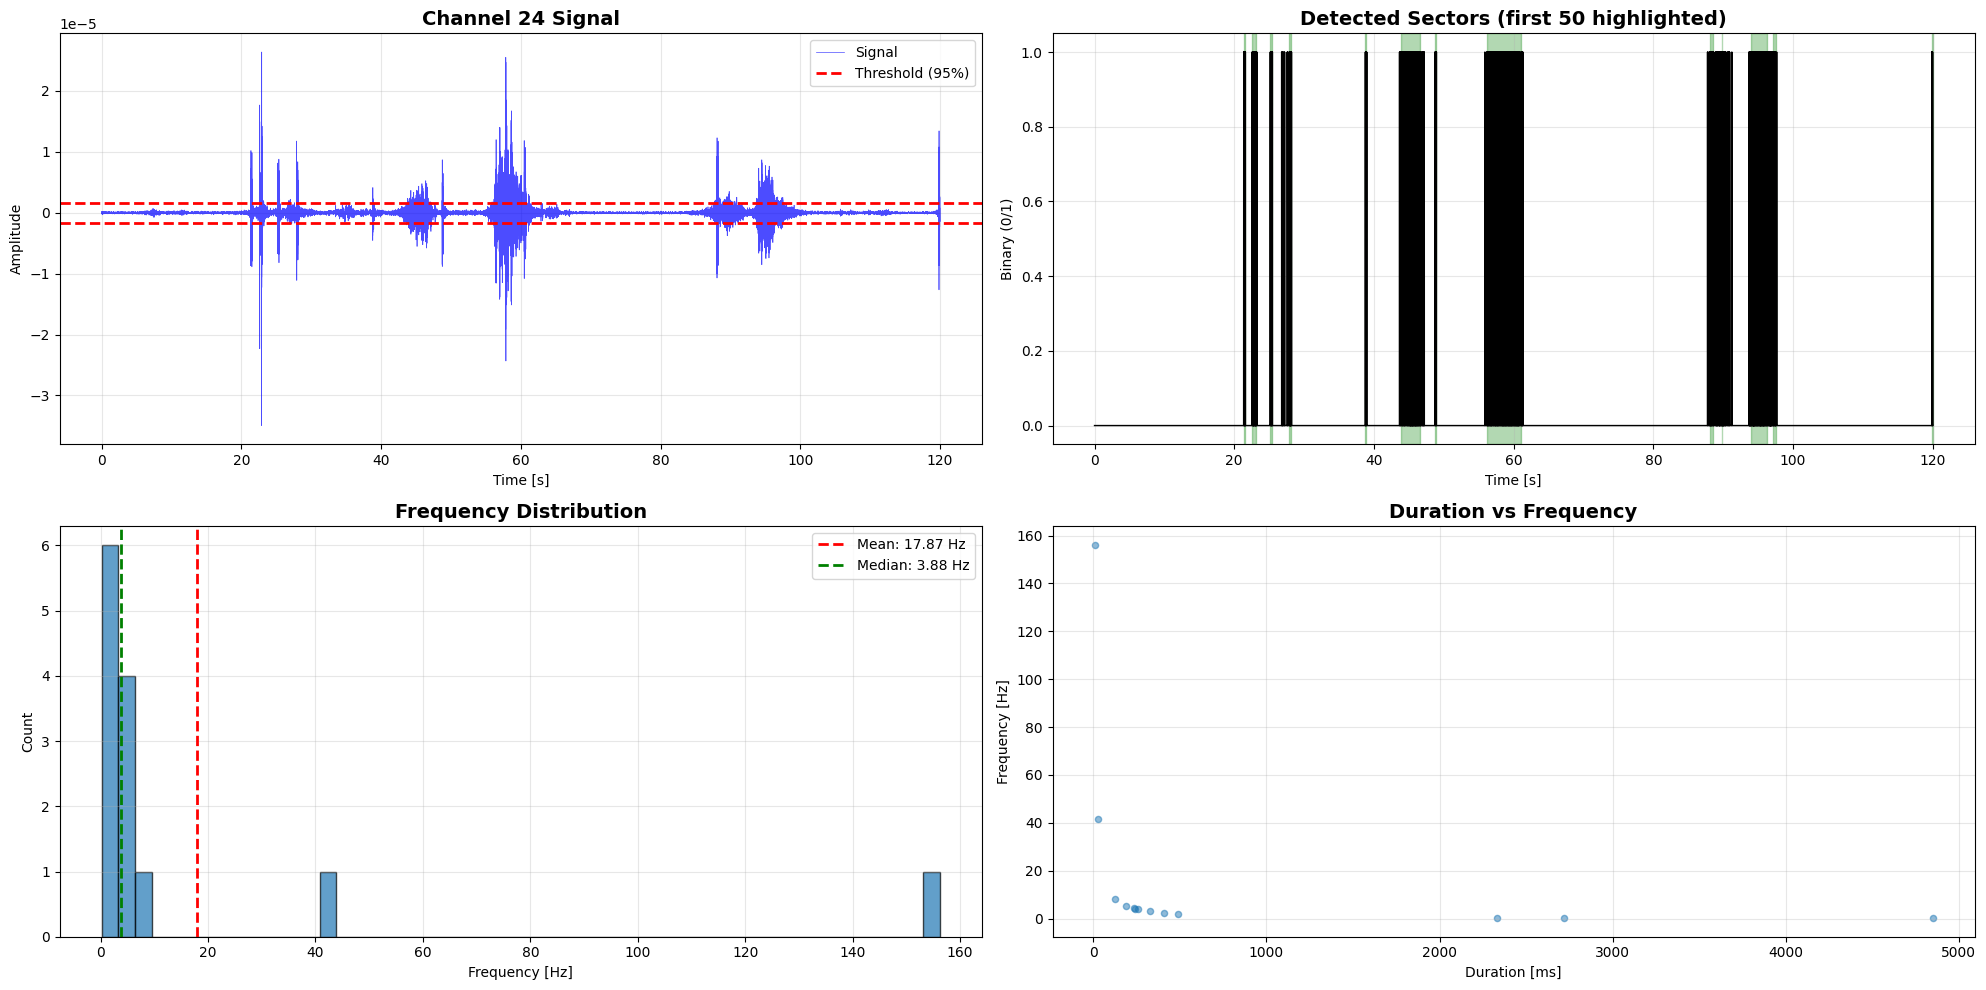


Detected frequencies: [  4.28082192   2.04918033   3.88198758   4.13907285  41.66666667
   0.36743092   5.38793103   0.20620257   2.46062992 156.25
   0.42925824   3.04878049   8.11688312]
BANDPASS KEEP ONLY SPECIFIC FREQUENCIES
Sampling frequency: 625.00 Hz
Keeping 13 frequency bands:
  Kept 1.78-6.78 Hz (center: 4.28 Hz)
  Skipping 2.05 Hz (band -0.45-4.55 Hz out of valid range)
  Kept 1.38-6.38 Hz (center: 3.88 Hz)
  Kept 1.64-6.64 Hz (center: 4.14 Hz)
  Kept 1.38-6.38 Hz (center: 3.88 Hz)
  Kept 1.64-6.64 Hz (center: 4.14 Hz)
  Kept 39.17-44.17 Hz (center: 41.67 Hz)
  Skipping 0.37 Hz (band -2.13-2.87 Hz out of valid range)
  Kept 2.89-7.89 Hz (center: 5.39 Hz)
  Skipping 0.21 Hz (band -2.29-2.71 Hz out of valid range)
  Skipping 2.46 Hz (band -0.04-4.96 Hz out of valid range)
  Kept 39.17-44.17 Hz (center: 41.67 Hz)
  Skipping 0.37 Hz (band -2.13-2.87 Hz out of valid range)
  Kept 2.89-7.89 Hz (center: 5.39 Hz)
  Skipping 0.21 Hz (band -2.29-2.71 Hz out of valid range)
  Skipping

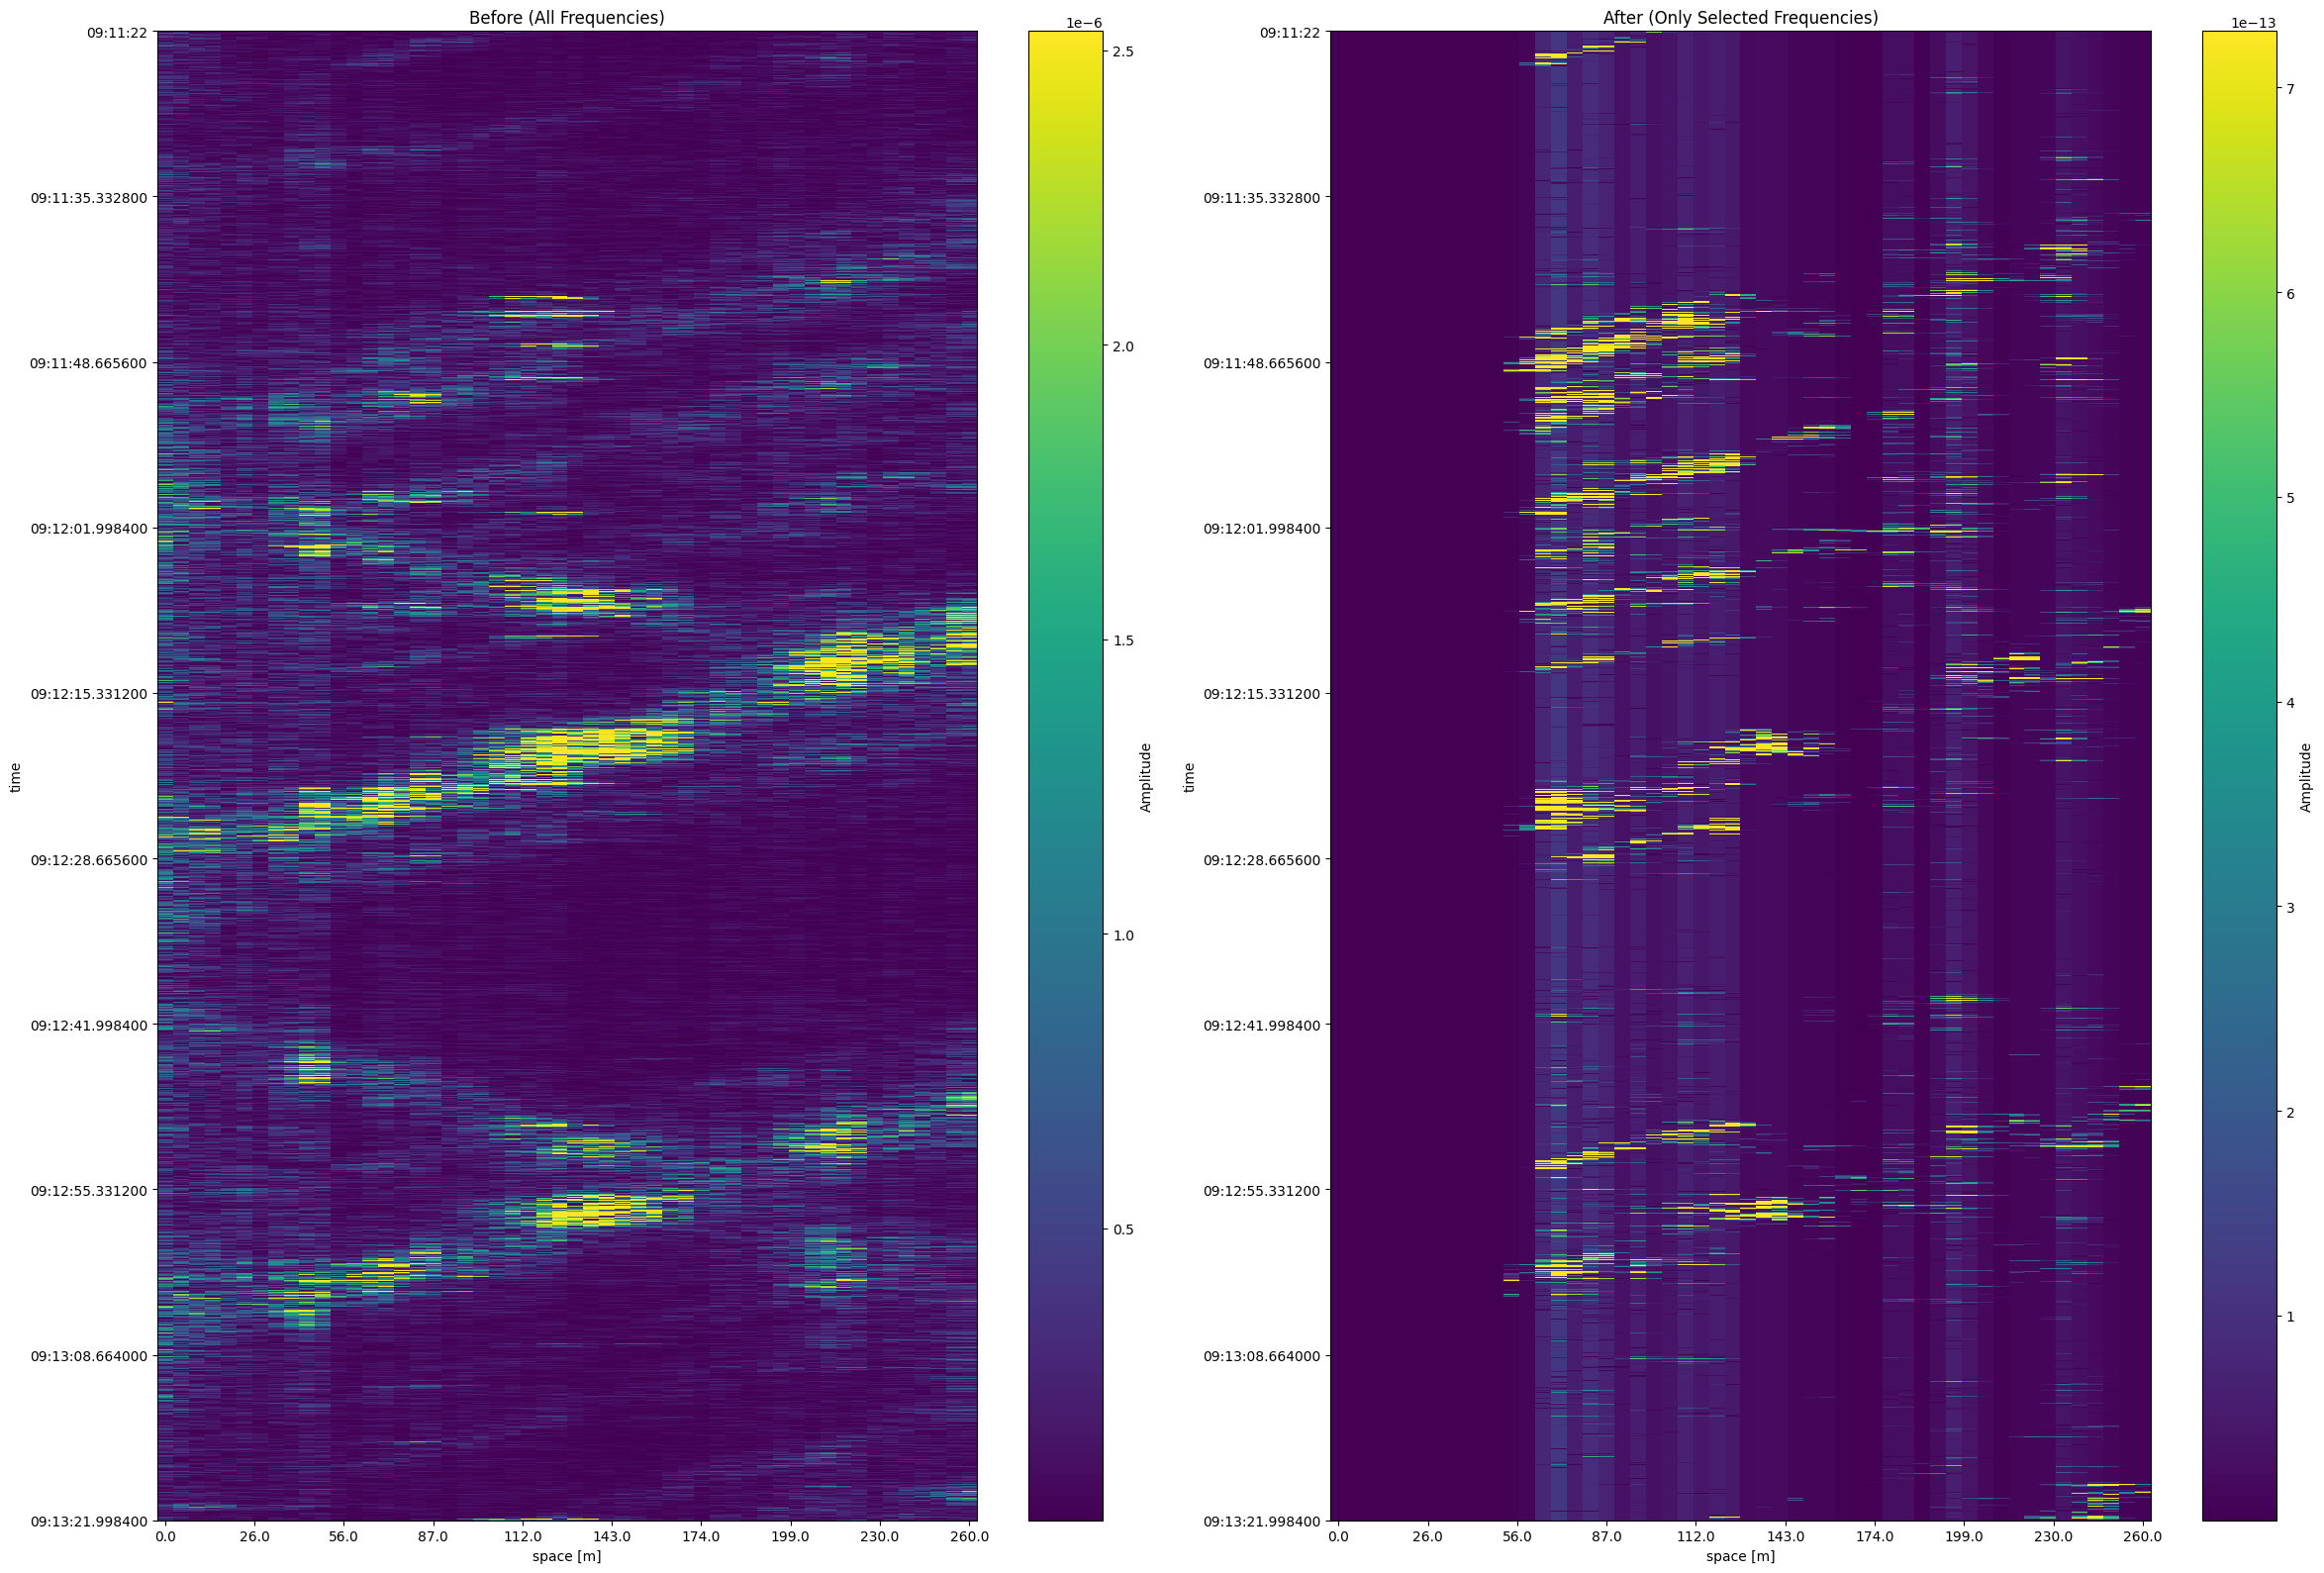

(<Figure size 2400x1600 with 4 Axes>,
 (<Axes: title={'center': 'Before (All Frequencies)'}, xlabel='space [m]', ylabel='time'>,
  <Axes: title={'center': 'After (Only Selected Frequencies)'}, xlabel='space [m]', ylabel='time'>))

In [229]:
raw_data = get_range(*range2)
removed_columns = zero_columns(raw_data, 0, 11)
#bandpass_data = bandpass_filter(removed_columns, lowcut=5, highcut=50, order=4)

# Find unwanted frequencies
result = find_channel_frequencies(removed_columns, channel_index=24, 
                                  threshold_percentile=95, 
                                  merge_gap=450)
print("Detected frequencies:", result['frequencies'])

# Keep ONLY detected frequencies, remove everything else
filtered_data = bandpass_keep_frequencies(removed_columns, result['frequencies'], bandwidth=5)
filtered_data = power_data_to_x(filtered_data, power=2)
filtered_data = percentile_filter(filtered_data, lower_percentile=90, upper_percentile=99)

# Compare before and after
plot_comparison(raw_data, filtered_data, 
                title1="Before (All Frequencies)", 
                title2="After (Only Selected Frequencies)")

Initial sectors detected: 419
CHANNEL 24 FFT FREQUENCY ANALYSIS

Data parameters:
  Temporal resolution (dt): 1.60 ms
  Sampling frequency (fs): 625.00 Hz
  Channel index: 24
  Threshold (percentile 95): 0.000001
  Merge gap: 450 samples (720.00 ms)
  Min sector length: 3 samples (4.80 ms)
  Frequency range: 5-50 Hz
  Top peaks per sector: 5
  Merged sectors detected: 9
  Total frequencies extracted: 45

DETECTED FREQUENCIES (via FFT):
#      Start      End        Length       Duration        Frequency    Power       
----------------------------------------------------------------------
1      0          3220       3220            5152.00 ms        43.67 Hz     3.03e-04
1      0          3220       3220            5152.00 ms        42.70 Hz     2.49e-04
1      0          3220       3220            5152.00 ms        43.48 Hz     2.13e-04
1      0          3220       3220            5152.00 ms        42.51 Hz     2.04e-04
1      0          3220       3220            5152.00 ms        43

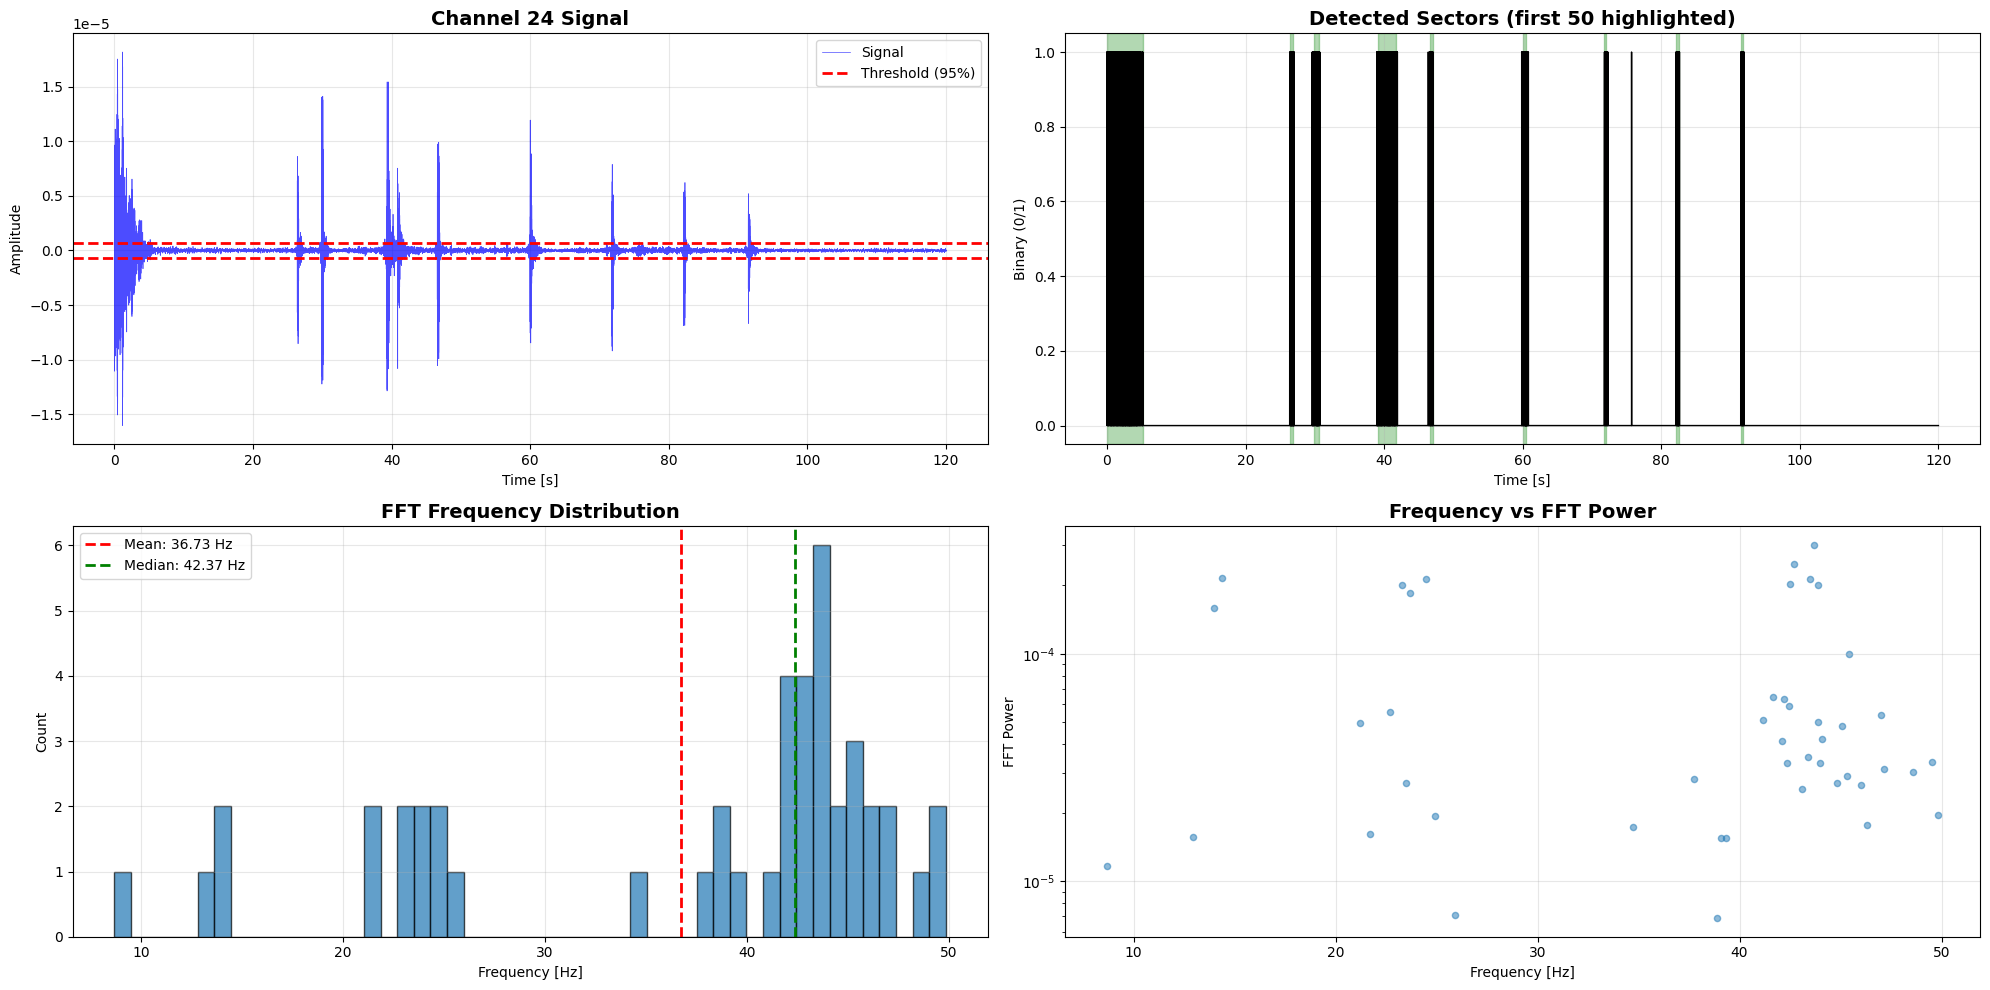



Detected frequencies (FFT): [43.67236025 42.70186335 43.47826087 42.50776398 43.86645963 42.17791411
 44.09509202 46.01226994 49.84662577 24.92331288 45.39951574 22.69975787
 43.88619855 21.18644068 42.37288136 14.36335404 24.45652174 23.29192547
 23.68012422 13.97515528 42.45283019 49.52830189 47.16981132 37.73584906
 44.81132075 41.66666667 43.98148148 48.61111111 46.2962963  39.35185185
 43.40277778 34.72222222 21.70138889 39.0625      8.68055556 47.02194357
 41.14420063 45.06269592 23.51097179 43.10344828 42.0984456  45.33678756
 12.95336788 25.90673575 38.86010363]
BANDPASS KEEP ONLY SPECIFIC FREQUENCIES
Sampling frequency: 625.00 Hz
Keeping 45 frequency bands:
  Kept 41.17-46.17 Hz (center: 43.67 Hz)
  Kept 40.20-45.20 Hz (center: 42.70 Hz)
  Kept 40.98-45.98 Hz (center: 43.48 Hz)
  Kept 40.20-45.20 Hz (center: 42.70 Hz)
  Kept 40.98-45.98 Hz (center: 43.48 Hz)
  Kept 40.01-45.01 Hz (center: 42.51 Hz)
  Kept 41.37-46.37 Hz (center: 43.87 Hz)
  Kept 40.01-45.01 Hz (center: 42.51

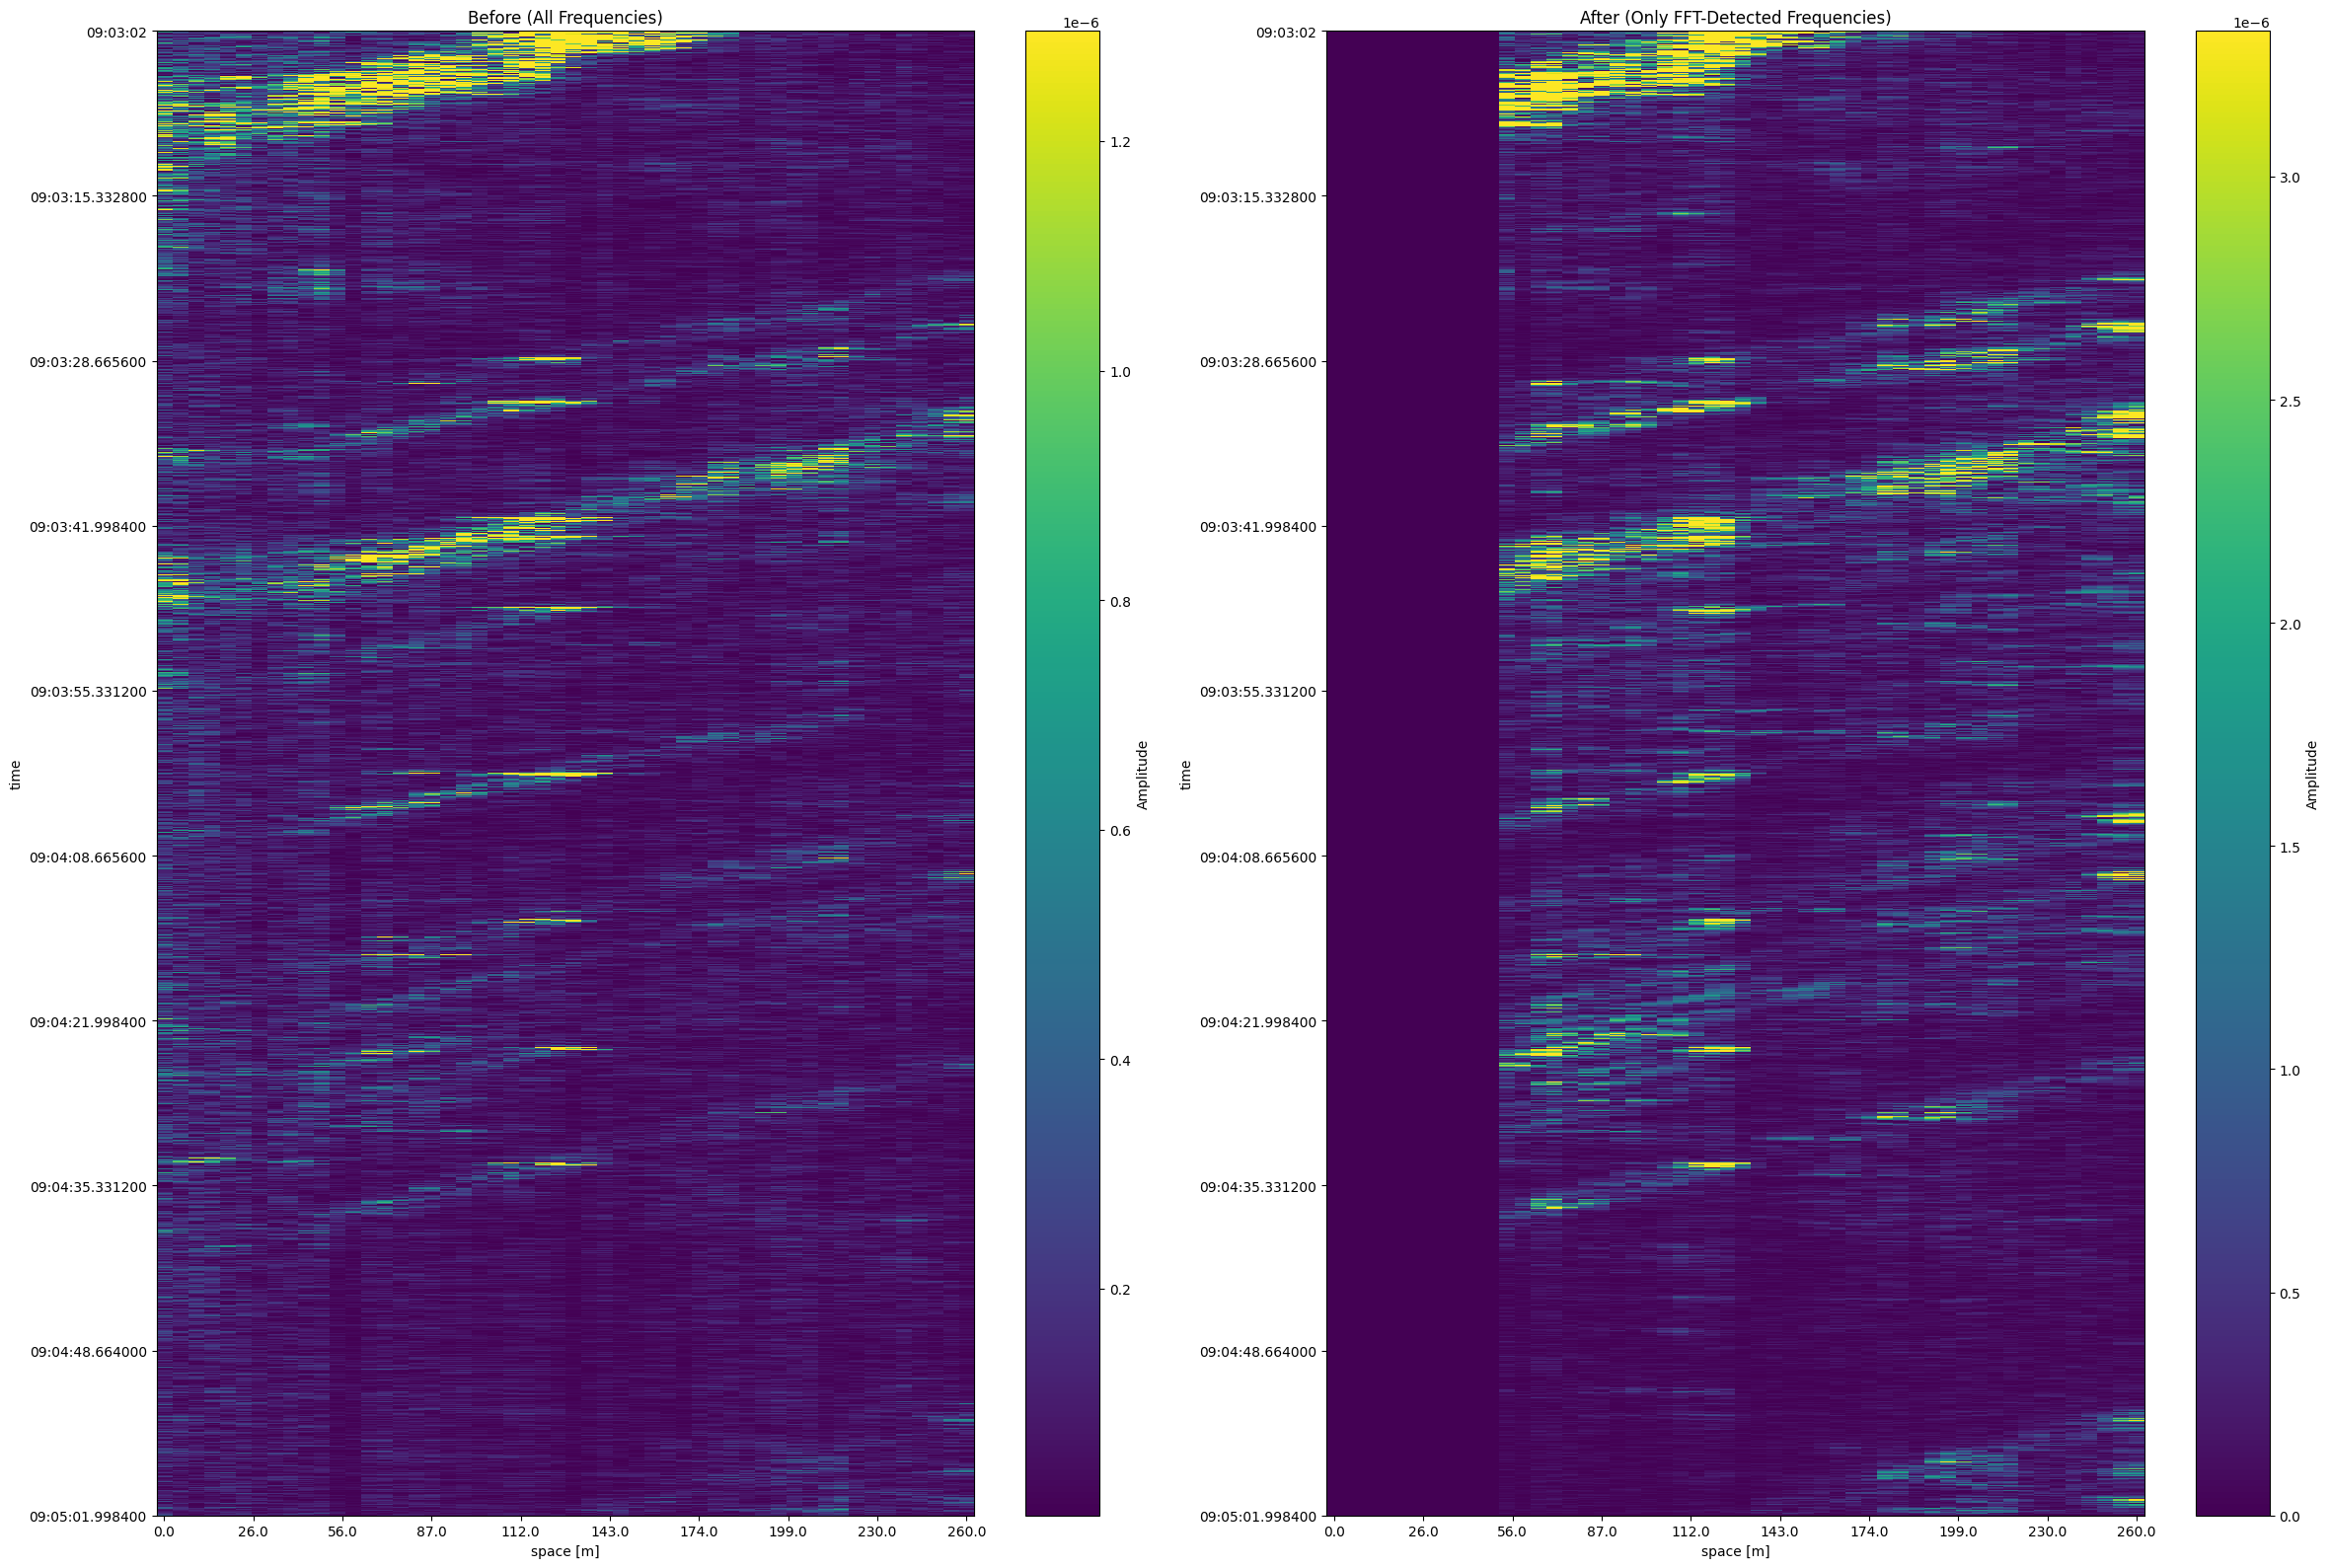

(<Figure size 2400x1600 with 4 Axes>,
 (<Axes: title={'center': 'Before (All Frequencies)'}, xlabel='space [m]', ylabel='time'>,
  <Axes: title={'center': 'After (Only FFT-Detected Frequencies)'}, xlabel='space [m]', ylabel='time'>))

In [271]:
# Test FFT-based frequency detection approach
raw_data = get_range(*range3)
data = zero_columns(raw_data, 0, 11)
bandbass_data = bandpass_filter(data, lowcut=5, highcut=50, order=4)
#data = power_data_to_x(bandbass_data, power=3)
#data = percentile_filter(data, lower_percentile=90, upper_percentile=99)

# Find frequencies using FFT analysis
result_fft = find_channel_frequencies_fft(data, 
                                          channel_index=24, 
                                          threshold_percentile=95, 
                                          merge_gap=450,
                                          min_freq=5,
                                          max_freq=50,
                                          top_n_peaks=5)
print("\nDetected frequencies (FFT):", result_fft['frequencies'])

# Keep ONLY detected frequencies
filtered_data = bandpass_keep_frequencies(data, 
                                         result_fft['frequencies'], 
                                         bandwidth=5)

# Compare before and after
plot_comparison(raw_data, filtered_data, 
                title1="Before (All Frequencies)", 
                title2="After (Only FFT-Detected Frequencies)")

Initial sectors detected: 699
CHANNEL 24 FFT FREQUENCY ANALYSIS

Data parameters:
  Temporal resolution (dt): 1.60 ms
  Sampling frequency (fs): 625.00 Hz
  Channel index: 24
  Threshold (percentile 95): 0.000001
  Merge gap: 450 samples (720.00 ms)
  Min sector length: 3 samples (4.80 ms)
  Frequency range: 5-50 Hz
  Top peaks per sector: 3
  Merged sectors detected: 16
  Total frequencies extracted: 43

DETECTED FREQUENCIES (via FFT):
#      Start      End        Length       Duration        Frequency    Power       
----------------------------------------------------------------------
1      13357      13519      162              259.20 ms        42.44 Hz     3.06e-05
1      13357      13519      162              259.20 ms        46.30 Hz     1.77e-05
1      13357      13519      162              259.20 ms        38.58 Hz     1.11e-05
2      14131      14682      551              881.60 ms        40.83 Hz     3.06e-05
2      14131      14682      551              881.60 ms        4

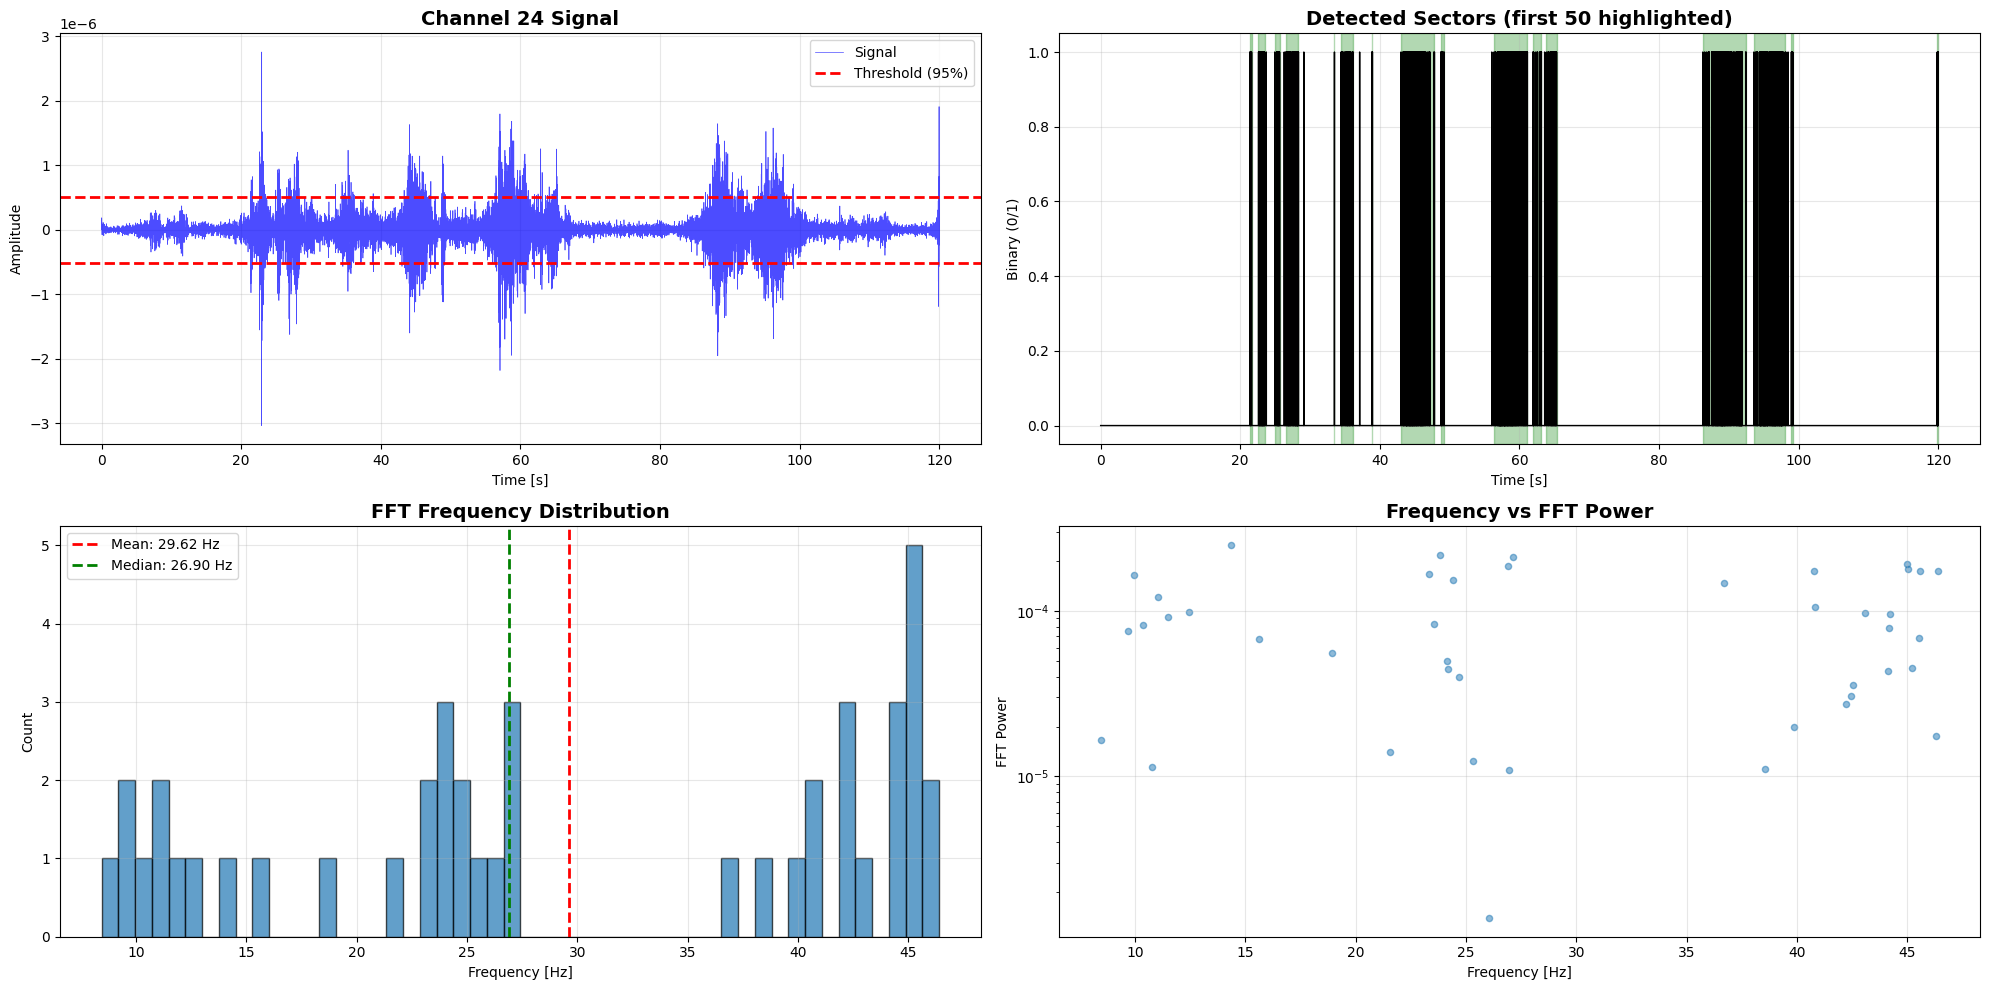



Detected frequencies (FFT): [42.4382716  46.2962963  38.58024691 40.83484574 43.10344828 44.23774955
 45.55808656 24.20273349 44.13439636  9.93816254 11.04240283 44.16961131
 11.49954002 10.34958602 24.14903404 26.04166667 45.04504505 24.3993994
 36.70337004 45.21276596 42.55319149 39.89361702 23.82943144 46.40468227
 45.56856187 15.625      18.91447368 24.67105263 12.45847176 23.53266888
  9.68992248 14.35113519 44.98839009 40.79592363 27.12557809 26.90323728
 23.34578442 21.55172414 10.77586207 26.93965517 42.22972973  8.44594595
 25.33783784]
NOTCH FILTERING
Sampling frequency: 625.00 Hz
Removing 43 frequencies:
  Removed 42.44 Hz (Q=8.49, BW=5.00 Hz)
  Removed 46.30 Hz (Q=9.26, BW=5.00 Hz)
  Removed 38.58 Hz (Q=7.72, BW=5.00 Hz)
  Removed 46.30 Hz (Q=9.26, BW=5.00 Hz)
  Removed 38.58 Hz (Q=7.72, BW=5.00 Hz)
  Removed 40.83 Hz (Q=8.17, BW=5.00 Hz)
  Removed 43.10 Hz (Q=8.62, BW=5.00 Hz)
  Removed 40.83 Hz (Q=8.17, BW=5.00 Hz)
  Removed 43.10 Hz (Q=8.62, BW=5.00 Hz)
  Removed 44.24

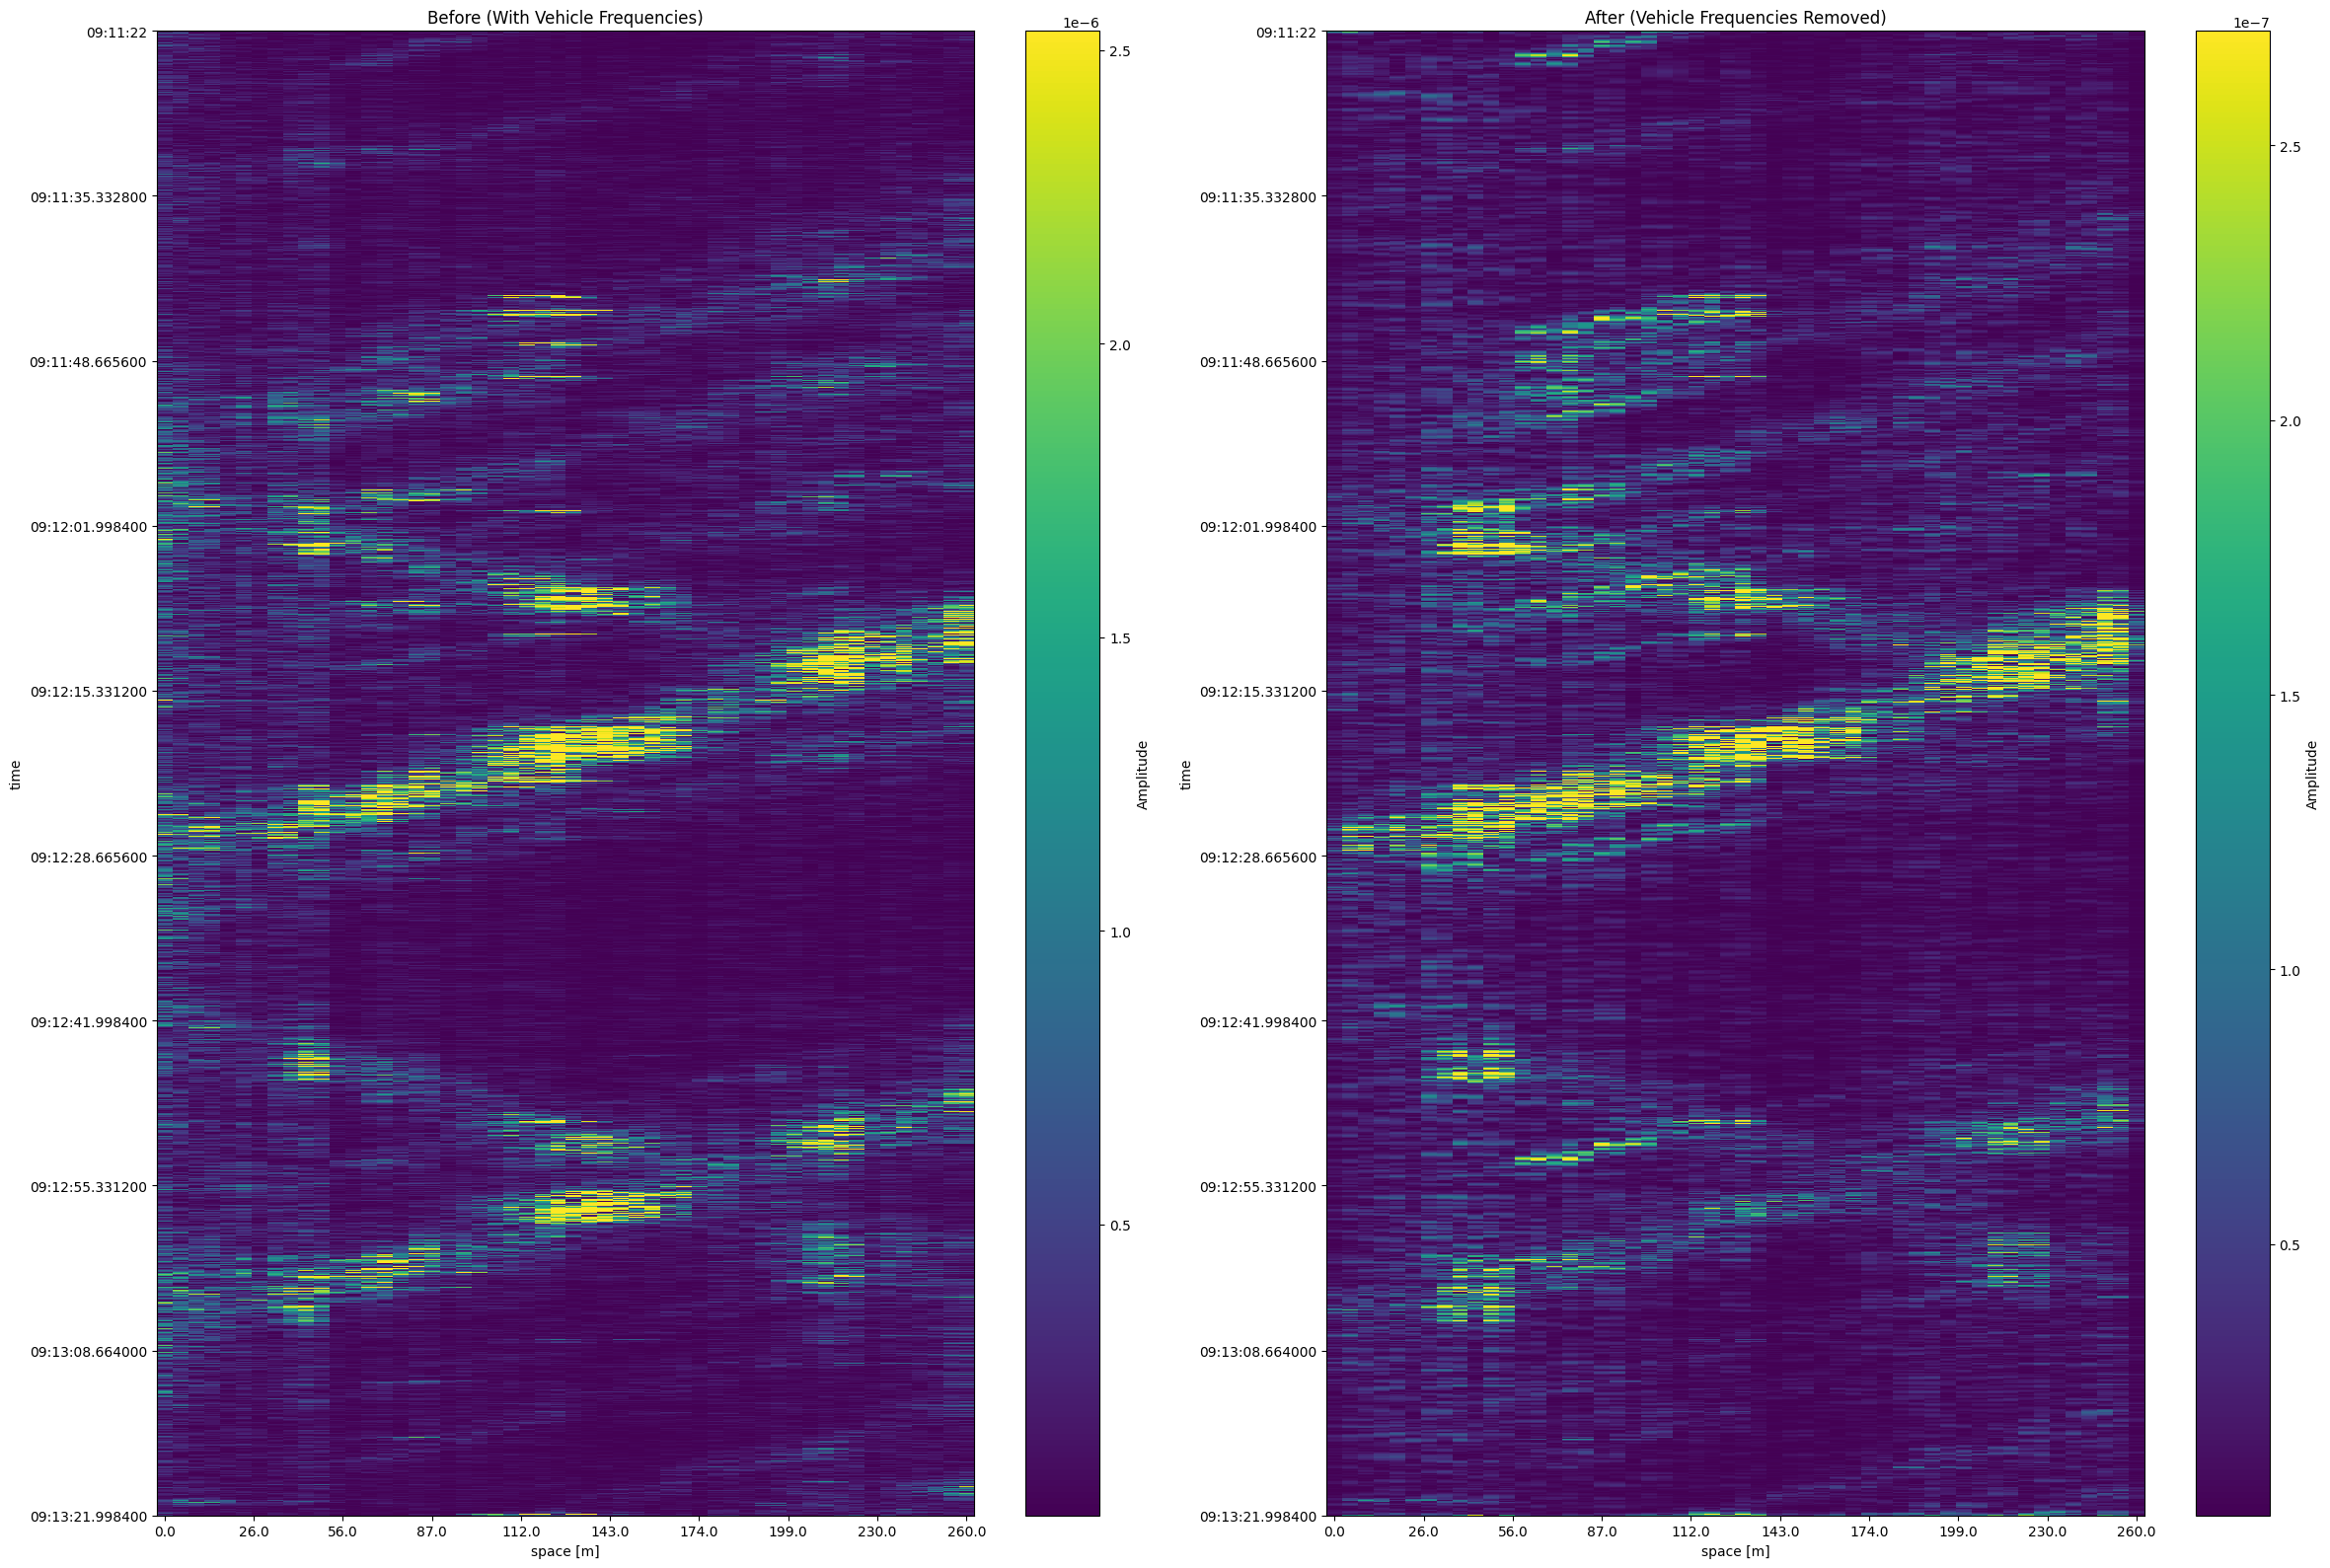

(<Figure size 2400x1600 with 4 Axes>,
 (<Axes: title={'center': 'Before (With Vehicle Frequencies)'}, xlabel='space [m]', ylabel='time'>,
  <Axes: title={'center': 'After (Vehicle Frequencies Removed)'}, xlabel='space [m]', ylabel='time'>))

In [295]:
# Test notch filter with FFT-detected frequencies
raw_data = get_range(*range2)
data = zero_columns(raw_data, 0, 0)
bandpass_data = bandpass_filter(data, lowcut=5, highcut=50, order=4)

# Find frequencies using FFT analysis
result_fft = find_channel_frequencies_fft(bandpass_data, 
                                          channel_index=24, 
                                          threshold_percentile=95, 
                                          merge_gap=450,
                                          min_freq=5,
                                          max_freq=50,
                                          top_n_peaks=3)
print("\nDetected frequencies (FFT):", result_fft['frequencies'])

# REMOVE detected frequencies using notch filter
filtered_data = notch_filter_frequencies(bandpass_data, 
                                        result_fft['frequencies'], 
                                        bandwidth=5.0)

filtered_data = horizontal_sobel_filter(filtered_data)
filtered_data = median_subtract_filter(filtered_data)

# Compare before and after
plot_comparison(raw_data, filtered_data, 
                title1="Before (With Vehicle Frequencies)", 
                title2="After (Vehicle Frequencies Removed)")